In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
!pip install torch-geometric
!pip install pandas scikit-learn matplotlib
!pip install seaborn


Looking in indexes: https://download.pytorch.org/whl/cpu
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cpu.html


ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [4]:
features_df = pd.read_csv("data/elliptic_txs_features.csv", header=None)
labels_df = pd.read_csv("data/elliptic_txs_classes.csv")
edges_df = pd.read_csv("data/elliptic_txs_edgelist.csv")

In [5]:
features_df = features_df.rename(columns={0: "txId", 1: "time_step"})
tx_ids = features_df["txId"].values
feature_cols = features_df.columns[2:]
X = features_df[feature_cols].values

labels_df = labels_df.rename(columns={"txId": "txId", "class": "label"})
labels_df = labels_df[labels_df["label"] != "unknown"]
labels_df["y"] = (labels_df["label"] == "1").astype(int)

labeled = features_df.merge(labels_df[["txId", "y"]], on="txId", how="left")
mask_labeled = labeled["y"].notna()
y_full = labeled["y"].fillna(-1).astype(int).values
time_steps = labeled["time_step"].values


In [6]:
tx_id_to_idx = {tx_id: i for i, tx_id in enumerate(tx_ids)}
edges_df = edges_df[edges_df["txId1"].isin(tx_id_to_idx) & edges_df["txId2"].isin(tx_id_to_idx)]
src = edges_df["txId1"].map(tx_id_to_idx).values
dst = edges_df["txId2"].map(tx_id_to_idx).values
edge_index = np.vstack((src, dst))
edge_index = np.concatenate((edge_index, np.vstack((dst, src))), axis=1)
edge_index = torch.tensor(edge_index, dtype=torch.long)

x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y_full, dtype=torch.long)


In [21]:
labeled_indices = np.where(y_full != -1)[0]
y_labeled = y_full[labeled_indices]

train_idx, test_idx = train_test_split(labeled_indices, test_size=0.2, stratify=y_labeled, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=y_full[train_idx], random_state=42)

train_mask = torch.zeros(x.size(0), dtype=torch.bool)
val_mask = torch.zeros(x.size(0), dtype=torch.bool)
test_mask = torch.zeros(x.size(0), dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True


In [8]:
data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask


In [9]:
X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

y_train = y_full[train_idx]
y_val = y_full[val_idx]
y_test = y_full[test_idx]

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train, y_train)

y_val_prob = log_reg.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_prob >= 0.5).astype(int)

y_test_prob = log_reg.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= 0.5).astype(int)

val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_prob)

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_prob)

baseline_test_auc = test_auc

print("Baseline Logistic Regression")
print("Val:  Acc:", val_acc, "F1:", val_f1, "AUC:", val_auc)
print("Test: Acc:", test_acc, "F1:", test_f1, "AUC:", test_auc)


Baseline Logistic Regression
Val:  Acc: 0.9647027244665146 F1: 0.8084486525855791 AUC: 0.9655740548749804
Test: Acc: 0.9619886180607753 F1: 0.7941860465116279 AUC: 0.967897182388396


In [10]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

train_labels = data.y[data.train_mask]
class_counts = torch.bincount(train_labels)
class_weights = (train_labels.size(0) / (2.0 * class_counts)).to(torch.float32).to(device)

model = GCN(in_channels=data.x.size(1), hidden_channels=64, out_channels=2, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)


In [12]:
def evaluate(split="val"):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        if split == "val":
            mask = data.val_mask
        elif split == "test":
            mask = data.test_mask
        else:
            mask = data.train_mask
        logits = out[mask]
        preds = logits.argmax(dim=1).cpu().numpy()
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        labels = data.y[mask].cpu().numpy()
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds)
        if len(np.unique(labels)) < 2:
            auc = float("nan")
        else:
            auc = roc_auc_score(labels, probs)
    return acc, f1, auc


In [13]:
epochs = 100
val_history = []
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0 or epoch == 1:
        val_acc, val_f1, val_auc = evaluate("val")
        val_history.append((epoch, val_acc, val_f1, val_auc))
        print(f"Epoch {epoch:03d} | Loss {loss.item():.4f} | Val Acc {val_acc:.4f} | Val F1 {val_f1:.4f} | Val AUC {val_auc:.4f}")


Epoch 001 | Loss 0.7402 | Val Acc 0.7735 | Val F1 0.1245 | Val AUC 0.6580
Epoch 005 | Loss 0.6146 | Val Acc 0.8028 | Val F1 0.3582 | Val AUC 0.8026
Epoch 010 | Loss 0.5125 | Val Acc 0.7926 | Val F1 0.4359 | Val AUC 0.8785
Epoch 015 | Loss 0.4609 | Val Acc 0.7885 | Val F1 0.4395 | Val AUC 0.8996
Epoch 020 | Loss 0.4208 | Val Acc 0.7908 | Val F1 0.4466 | Val AUC 0.9098
Epoch 025 | Loss 0.3953 | Val Acc 0.8053 | Val F1 0.4656 | Val AUC 0.9172
Epoch 030 | Loss 0.3709 | Val Acc 0.8199 | Val F1 0.4831 | Val AUC 0.9234
Epoch 035 | Loss 0.3574 | Val Acc 0.8320 | Val F1 0.5004 | Val AUC 0.9285
Epoch 040 | Loss 0.3499 | Val Acc 0.8388 | Val F1 0.5104 | Val AUC 0.9326
Epoch 045 | Loss 0.3308 | Val Acc 0.8457 | Val F1 0.5212 | Val AUC 0.9359
Epoch 050 | Loss 0.3261 | Val Acc 0.8518 | Val F1 0.5318 | Val AUC 0.9385
Epoch 055 | Loss 0.3128 | Val Acc 0.8565 | Val F1 0.5406 | Val AUC 0.9406
Epoch 060 | Loss 0.3132 | Val Acc 0.8610 | Val F1 0.5484 | Val AUC 0.9427
Epoch 065 | Loss 0.3069 | Val Acc 0.86

In [14]:
test_acc, test_f1, test_auc = evaluate("test")
print("GCN Test Performance")
print("Acc:", test_acc, "F1:", test_f1, "AUC:", test_auc)


GCN Test Performance
Acc: 0.8859658541823258 F1: 0.6010518407212622 AUC: 0.9554116406405039


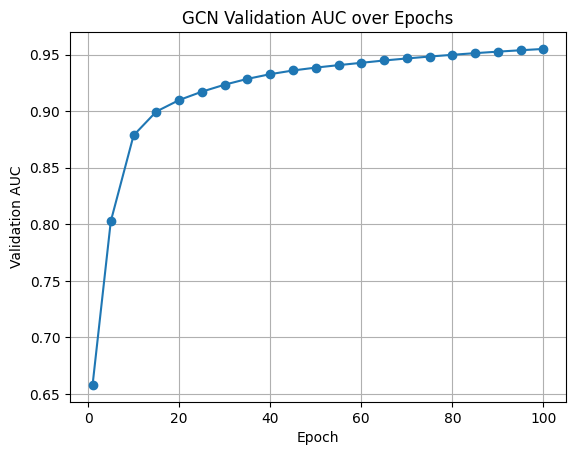

In [15]:
epochs_list = [e for e, a, f, u in val_history]
auc_list = [u for e, a, f, u in val_history]

plt.figure()
plt.plot(epochs_list, auc_list, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation AUC")
plt.title("GCN Validation AUC over Epochs")
plt.grid(True)
plt.show()


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    logits_test = out[data.test_mask]
    y_test_true = data.y[data.test_mask].cpu().numpy()
    y_test_pred = logits_test.argmax(dim=1).cpu().numpy()

cm = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred, digits=4))


Confusion Matrix:
[[7451  953]
 [ 109  800]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9856    0.8866    0.9335      8404
           1     0.4564    0.8801    0.6011       909

    accuracy                         0.8860      9313
   macro avg     0.7210    0.8833    0.7673      9313
weighted avg     0.9339    0.8860    0.9010      9313



In [17]:
edge_index_cpu = data.edge_index.cpu()
fraud_mask = (data.y == 1).cpu()
neighbor_ratios = []

for i in test_idx:
    neighbors = edge_index_cpu[1][edge_index_cpu[0] == i]
    if neighbors.numel() > 0:
        ratio = fraud_mask[neighbors].float().mean().item()
        neighbor_ratios.append(ratio)

if len(neighbor_ratios) > 0:
    avg_ratio = float(np.mean(neighbor_ratios))
    print("Average fraudulent neighbor ratio for test nodes:", avg_ratio)


Average fraudulent neighbor ratio for test nodes: 0.03228519355597627


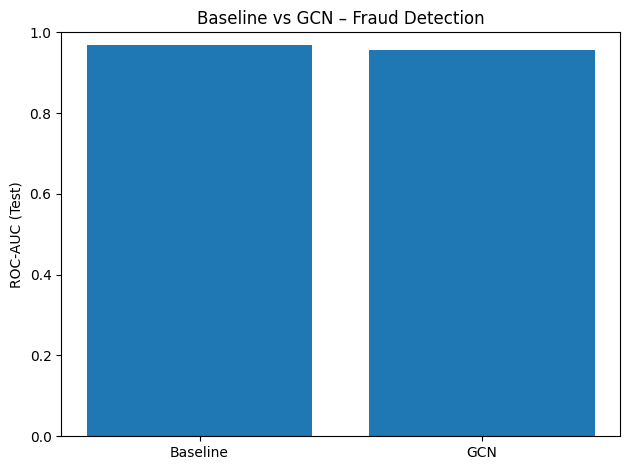

In [18]:
models = ["Baseline", "GCN"]
auc_scores = [baseline_test_auc, test_auc]

plt.figure()
plt.bar(models, auc_scores)
plt.ylabel("ROC-AUC (Test)")
plt.title("Baseline vs GCN – Fraud Detection")
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


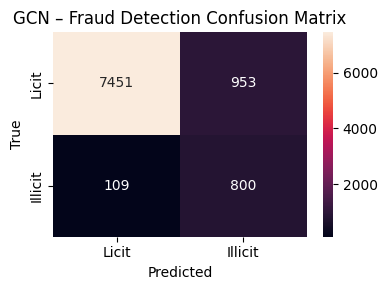

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Licit", "Illicit"], yticklabels=["Licit", "Illicit"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GCN – Fraud Detection Confusion Matrix")
plt.tight_layout()
plt.show()
